### Comparing multiple runs at selected locations

Hovmoller plots of temp, salt, N2, and BLD at selected locations.

Gustavo Marques (gmarques@ucar.edu)

In [1]:
from datetime import date
print("Last update:", date.today())

Last update: 2023-01-10


## Brief summary of the experiments 

* 1) CTRL-Z* 
* 2) LBD-Z* = CTRL-Z* + LBD + NNDIFF interior
* 3) CTRL-H 
* 4) LBD-H = CTRL-H + LBD + NNDIFF interior

They were all run for one cycle of the JRA-55 v1.3 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import warnings, os
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.stats import mean_da
from mom6_tools.m6toolbox import request_workers, genBasinMasks, add_global_attrs 
from mom6_tools.m6plot import ztplot, xyplot
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

Basemap module not found. Some regional plots may not function properly


/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
path = '/glade/scratch/gmarques/'
path2 = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/G/'
exps = ['gmom.e23.GJRAv4.TL319_t061_zstar_N65.nuopc.baseline.002', \
        'gmom.e23.GJRAv4.TL319_t061_zstar_N65.nuopc.HBD.002',  \
        'gmom.e23.GJRAv4.TL319_t061_hycom1_N75.nuopc.baseline.002',\
        'gmom.e23.GJRAv4.TL319_t061_hycom1_N75.nuopc.HBD.002']
labels = ['CTRL-z*', 'HBD-z*',  'CTRL-H', 'HBD-H']

# set this to true to save the plots
saveplot = True
if saveplot:
    os.system('mkdir PNG')

mkdir: cannot create directory ‘PNG’: File exists


In [4]:
# load grid and pre-difined masks
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)
# get ocean area, xarray format
grd_xr = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc',xrformat=True)
area = grd_xr.area_t.where(grd.wet > 0)

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]
MOM6 grid successfully loaded... 



In [5]:
basin_code['yh'] = grd_xr.yh
basin_code['xh'] = grd_xr.xh

In [6]:
# load WOA18 data
obs_path = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/WOA18_remapping/'
thetao_obs = xr.open_dataset(obs_path+'WOA18_TEMP_tx0.66v1_34lev_monthly_avg.nc', 
                             decode_times=True)
salt_obs = xr.open_dataset(obs_path+'WOA18_SALT_tx0.66v1_34lev_monthly_avg.nc', 
                           decode_times=True)

In [7]:
thetao_obs['xh'] = grd_xr.xh
salt_obs['xh'] = grd_xr.xh
thetao_obs['yh'] = grd_xr.yh
salt_obs['yh'] = grd_xr.yh

In [8]:
# load woa18 from MOM output
mom_path = '/glade/scratch/gmarques/hbd_stratification_woa18/run/'

In [9]:
# January, February, March
woa_jan = xr.open_dataset(mom_path+'JAN/hbd_stratification_woa18.mom6.h_0001_01.nc').isel(time=0)
woa_feb = xr.open_dataset(mom_path+'FEB/hbd_stratification_woa18.mom6.h_0001_01.nc').isel(time=0)
woa_mar = xr.open_dataset(mom_path+'MAR/hbd_stratification_woa18.mom6.h_0001_01.nc').isel(time=0)
woa_jfm = xr.combine_nested([woa_jan,woa_feb,woa_mar],concat_dim=['time'])

In [10]:
# July, August, Sep
woa_jul = xr.open_dataset(mom_path+'JUL/hbd_stratification_woa18.mom6.h_0001_01.nc').isel(time=0)
woa_aug = xr.open_dataset(mom_path+'AUG/hbd_stratification_woa18.mom6.h_0001_01.nc').isel(time=0)
woa_sep = xr.open_dataset(mom_path+'SEP/hbd_stratification_woa18.mom6.h_0001_01.nc').isel(time=0)
woa_jas = xr.combine_nested([woa_jul,woa_aug,woa_sep],concat_dim=['time'])

### Lab Sea 
Regional-averaged ocean properties during winter time (JFM)

Max. depth in LabSea is: 4109.0


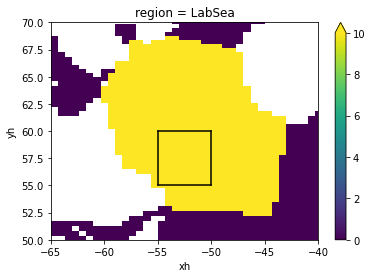

In [11]:
fig, ax = plt.subplots()
(basin_code.sel(region='LabSea')*grd_xr.depth_ocean).plot(ax=ax,vmax=10)
#(basin_code.sel(region='LabSea').sel(xh=slice(-55, -50)).sel(yh=slice(55, 60))*grd_xr.depth_ocean).plot(ax=ax)
ax.plot([-55,-50],[55.,55],'k')
ax.plot([-55,-50],[60.,60],'k')
ax.plot([-55,-55],[55.,60],'k')
ax.plot([-50,-50],[55.,60],'k')
#ax.plot(-53.0,60.,'o')
ax.set_xlim(-65,-40)
ax.set_ylim(50,70)

print('Max. depth in LabSea is:',(basin_code.sel(region='LabSea')*grd_xr.depth_ocean).max().values)

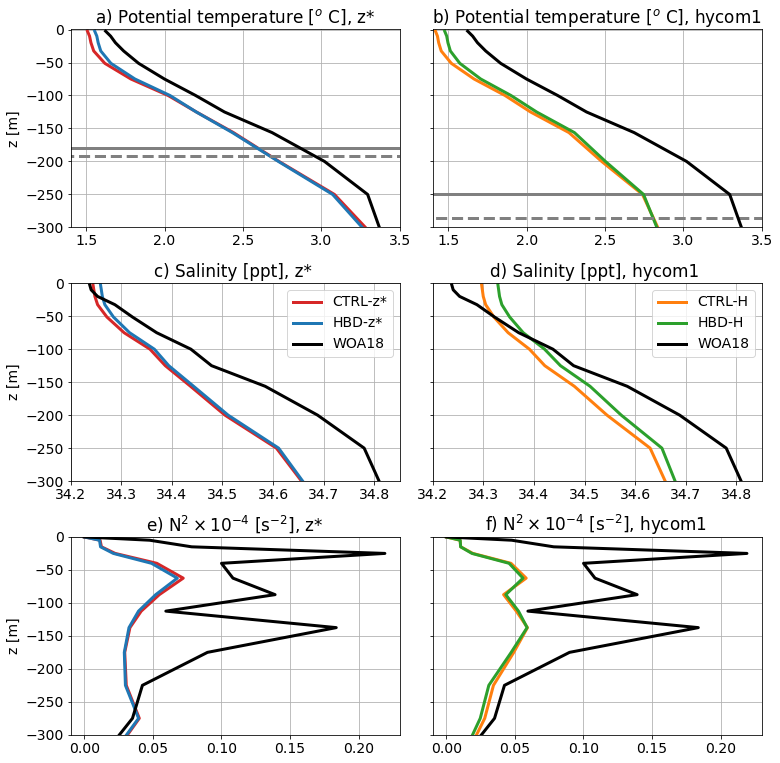

In [19]:
# profiles
#import seaborn as sns
#sns.set_theme(style="whitegrid")
matplotlib.rcParams.update({'font.size': 14})

# temperature
var = 'thetao'
reg='LabSea'
months = [0,1,2]
max_depth = 400.
lw=3

salt_obs_lab = woa_jfm.so.sel(xh=slice(-55, -50)).sel(yh=slice(55, 
                            60)).mean(dim=['xh','yh']).sel(z_l=slice(0,max_depth)).mean('time')


thetao_obs_lab = woa_jfm.thetao.sel(xh=slice(-55, -50)).sel(yh=slice(55, 
                            60)).mean(dim=['xh','yh']).sel(z_l=slice(0,max_depth)).mean('time')


obs_N2_lab = woa_jfm.obvfsq.sel(xh=slice(-55, -50)).sel(yh=slice(55, 
                            60)).mean(dim=['xh','yh']).sel(z_i=slice(0,max_depth)).mean('time')

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14), sharey=True)
#plt.suptitle('Potential Temperature [C], LabSea', y=0.96)
ax1 = ax.flatten()
colors = ['tab:red','tab:blue','tab:orange','tab:green']

for i in range(len(exps)):
  ds = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_winter_tracer_z_point_'+reg+'.nc')
  ds = ds.sel(z_l=slice(0,max_depth))
  ds1 = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_winter_oml_point_'+reg+'.nc')
  ds2 = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_winter_N2_point_'+reg+'.nc')
  ds2 = ds2.sel(z_i=slice(0,max_depth))

  oml = ds1.oml.values#.mean('time').values
  thetao = np.ma.masked_invalid(ds['thetao'].values)
  so = np.ma.masked_invalid(ds['so'].values)
  N2 = np.ma.masked_invalid(ds2['N2'].values)

  if i < 2:
    # z*
    if i == 0:
      ax1[0].plot(thetao,-ds.z_l.values, color=colors[i], label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, color=colors[i], label=labels[i], lw=lw)
      ax1[4].plot(N2*1e4,-ds2.z_i.values, color=colors[i], label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[0].plot(thetao,-ds.z_l.values, color=colors[i],label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, color=colors[i], label=labels[i], lw=lw)
      ax1[4].plot(N2*1e4,-ds2.z_i.values, color=colors[i], label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'--',color='gray', lw=lw)
    

  else:
    ax1[1].plot(thetao,-ds.z_l.values, color=colors[i], label=labels[i], lw=lw)
    if i == 2:
      ax1[1].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[1].plot([0,6],-np.ones(2)*oml,'--', color='gray', lw=lw)
    
    ax1[3].plot(so,-ds.z_l.values, label=labels[i], color=colors[i], lw=lw)
    ax1[5].plot(N2*1e4,-ds2.z_i.values, label=labels[i], color=colors[i], lw=lw)
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.28)

# obs
ax1[0].plot(thetao_obs_lab.values, -thetao_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[1].plot(thetao_obs_lab.values, -thetao_obs_lab.z_l.values,'k',label='WOA18', lw=lw)

ax1[2].plot(salt_obs_lab.values, -salt_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[3].plot(salt_obs_lab.values, -salt_obs_lab.z_l.values,'k',label='WOA18', lw=lw)

ax1[4].plot(obs_N2_lab.values*1e4, -obs_N2_lab.z_i.values,'k',label='WOA18', lw=lw)
ax1[5].plot(obs_N2_lab.values*1e4, -obs_N2_lab.z_i.values,'k',label='WOA18', lw=lw)

# grid
ax1[0].grid();ax1[1].grid()
ax1[2].grid();ax1[3].grid()
ax1[4].grid();ax1[5].grid()

# titles
ax1[0].set_title(r'a) Potential temperature [$^o$ C], z* ')
ax1[1].set_title(r'b) Potential temperature [$^o$ C], hycom1 ')
ax1[2].set_title(r'c) Salinity [ppt], z* ')
ax1[3].set_title(r'd) Salinity [ppt], hycom1 ')
ax1[4].set_title(r'e) N$^2 \times 10^{-4}$ [s$^{-2}$], z* ')
ax1[5].set_title(r'f) N$^2 \times 10^{-4}$ [s$^{-2}$], hycom1 ')

# ylabels
ax1[0].set_ylabel(r'z [m]')
ax1[2].set_ylabel(r'z [m]')
ax1[4].set_ylabel(r'z [m]')

# labels
ax1[2].legend()
ax1[3].legend()

# lims
ax1[0].set_xlim(1.4,3.5)
ax1[1].set_xlim(1.4,3.5)
ax1[2].set_xlim(34.2,34.85)
ax1[3].set_xlim(34.2,34.85)
ax1[4].set_xlim(-0.01,0.23)
ax1[5].set_xlim(-0.01,0.23)

ax1[0].set_ylim(-300,0.5)
if saveplot:
    fname = 'PNG/profiles_lab_sea.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

### SouthernOcean 
Regional-averaged ocean properties during winter (JAS)

Max. depth in SouthernOcean is: 6000.0


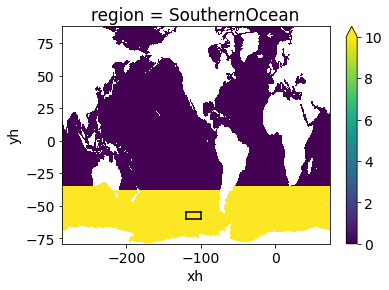

In [16]:
fig, ax = plt.subplots()
(basin_code.sel(region='SouthernOcean')*grd_xr.depth_ocean).plot(ax=ax,vmax=10)
#(basin_code.sel(region='SouthernOcean')*grd_xr.depth_ocean).sel(xh=slice(-150, -110)).sel(yh=slice(-60, -50)).plot(ax=ax)
ax.plot([-120,-100],[-60.,-60.],'k')
ax.plot([-120,-100],[-55.,-55.],'k')
ax.plot([-120,-120],[-60.,-55.],'k')
ax.plot([-100,-100],[-60.,-55.],'k')
#ax.plot([-110.],[-60.],'ko')

#ax.set_xlim(-152,-105)
#ax.set_ylim(-60,-50)

print('Max. depth in SouthernOcean is:',(basin_code.sel(region='SouthernOcean')*grd_xr.depth_ocean).max().values)

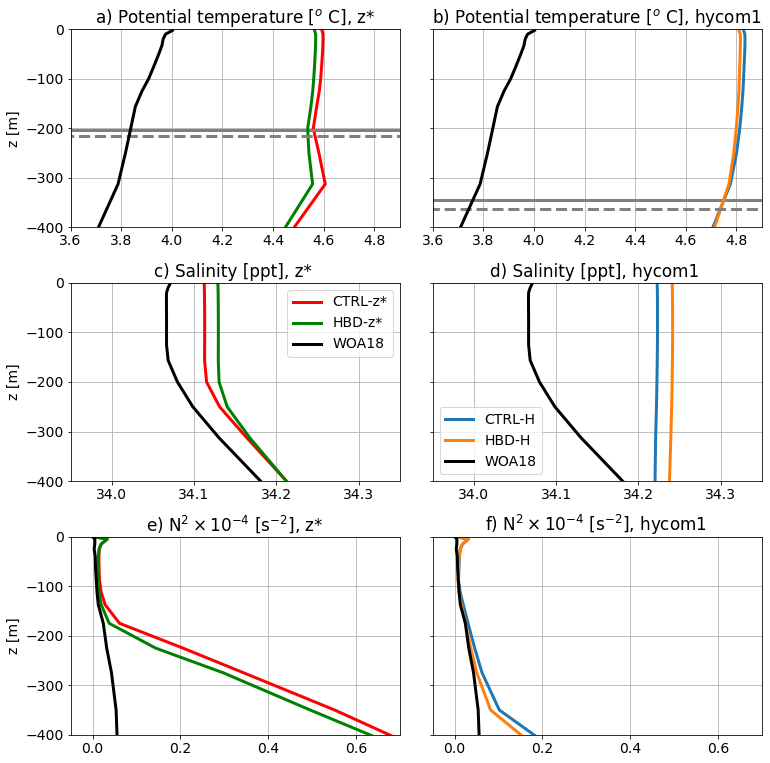

In [21]:
# profiles
matplotlib.rcParams.update({'font.size': 14})

reg='SouthernOcean'
max_depth = 450.
lw=3

salt_obs_so = woa_jas.so.sel(xh=slice(-120, -100)).sel(yh=slice(-60.,
                            -55.)).mean(dim=['xh','yh']).sel(z_l=slice(0,max_depth)).mean('time')


thetao_obs_so = woa_jas.thetao.sel(xh=slice(-120, -100)).sel(yh=slice(-60., 
                            -55.)).mean(dim=['xh','yh']).sel(z_l=slice(0,max_depth)).mean('time')


obs_N2_so = woa_jas.obvfsq.sel(xh=slice(-120, -100)).sel(yh=slice(-60., 
                            -55.)).mean(dim=['xh','yh']).sel(z_i=slice(0,max_depth)).mean('time')


matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14), sharey=True)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_winter_tracer_z_point_'+reg+'.nc')
  ds = ds.sel(z_l=slice(0,max_depth))
  ds1 = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_winter_oml_point_'+reg+'.nc')
  ds2 = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_winter_N2_point_'+reg+'.nc')
  ds2 = ds2.sel(z_i=slice(0,max_depth))

  oml = ds1.oml.values
  thetao = np.ma.masked_invalid(ds['thetao'].values)
  so = np.ma.masked_invalid(ds['so'].values)
  N2 = np.ma.masked_invalid(ds2['N2'].values)

  if i < 2:
    # z*
    if i == 0:
      ax1[0].plot(thetao,-ds.z_l.values, 'r', label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, 'r', label=labels[i], lw=lw)
      ax1[4].plot(N2*1e5,-ds2.z_i.values, 'r', label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[0].plot(thetao,-ds.z_l.values, 'g',label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, 'g', label=labels[i], lw=lw)
      ax1[4].plot(N2*1e5,-ds2.z_i.values, 'g', label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'--',color='gray', lw=lw)
    

  else:
    ax1[1].plot(thetao,-ds.z_l.values, label=labels[i], lw=lw)
    if i == 2:
      ax1[1].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[1].plot([0,6],-np.ones(2)*oml,'--', color='gray', lw=lw)
    
    ax1[3].plot(so,-ds.z_l.values, label=labels[i], lw=lw)
    ax1[5].plot(N2*1e5,-ds2.z_i.values, label=labels[i], lw=lw)
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.28)

# obs
ax1[0].plot(thetao_obs_so.values, -thetao_obs_so.z_l.values,'k',label='WOA18', lw=lw)
ax1[1].plot(thetao_obs_so.values, -thetao_obs_so.z_l.values,'k',label='WOA18', lw=lw)

ax1[2].plot(salt_obs_so.values, -salt_obs_so.z_l.values,'k',label='WOA18', lw=lw)
ax1[3].plot(salt_obs_so.values, -salt_obs_so.z_l.values,'k',label='WOA18', lw=lw)

ax1[4].plot(obs_N2_so.values*1e4, -obs_N2_so.z_i.values,'k',label='WOA18', lw=lw)
ax1[5].plot(obs_N2_so.values*1e4, -obs_N2_so.z_i.values,'k',label='WOA18', lw=lw)

# grid
ax1[0].grid();ax1[1].grid()
ax1[2].grid();ax1[3].grid()
ax1[4].grid();ax1[5].grid()

# titles
ax1[0].set_title(r'a) Potential temperature [$^o$ C], z* ')
ax1[1].set_title(r'b) Potential temperature [$^o$ C], hycom1 ')
ax1[2].set_title(r'c) Salinity [ppt], z* ')
ax1[3].set_title(r'd) Salinity [ppt], hycom1 ')
ax1[4].set_title(r'e) N$^2 \times 10^{-4}$ [s$^{-2}$], z* ')
ax1[5].set_title(r'f) N$^2 \times 10^{-4}$ [s$^{-2}$], hycom1 ')

# ylabels
ax1[0].set_ylabel(r'z [m]')
ax1[2].set_ylabel(r'z [m]')
ax1[4].set_ylabel(r'z [m]')

# labels
ax1[2].legend()
ax1[3].legend()

# lims
ax1[0].set_xlim(3.6,4.9)
ax1[1].set_xlim(3.6,4.9)
ax1[2].set_xlim(33.95,34.35)
ax1[3].set_xlim(33.95,34.35)
ax1[4].set_xlim(-0.05,0.7)
ax1[5].set_xlim(-0.05,0.7)

ax1[0].set_ylim(-400,0)
#ax1[0].invert_yaxis()
if saveplot:
    fname = 'PNG/profiles_southern_ocean.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)